In [42]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import Dict, List, Optional, Union, cast
import requests
from env import github_token, github_username
import unicodedata
import nltk
import prepare as p
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from scipy import stats

In [3]:
url = "https://github.com/search?3&q=stars%3A%3E0&s=stars&type=Repositories"
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')
urls = []
for link in soup.find_all('a',class_="v-align-middle"):
    print(link.get('href'))

/go-xorm/xorm
/gss/engine
/kandanapp/kandan
/aanand/git-up
/Naoki2015/CircleDemo
/wavded/humane-js
/soulwire/fit.js
/Haneke/Haneke
/dchelimsky/rspec
/Trinea/android-auto-scroll-view-pager


In [4]:
url = "https://github.com/search?3&q=stars%3A%3E0&s=stars&type=Repositories"
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')
urls = []
for link in soup.find_all('a',class_="v-align-middle"):
    urls.append(link.get('href'))

In [5]:
REPOS = urls_repo['0']

headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )


def github_api_request(url: str) -> Union[List, Dict]:
    response = requests.get(url, headers=headers)
    response_data = response.json()
    if response.status_code != 200:
        raise Exception(
            f"Error response from github api! status code: {response.status_code}, "
            f"response: {json.dumps(response_data)}"
        )
    return response_data


def get_repo_language(repo: str) -> str:
    url = f"https://api.github.com/repos/{repo}"
    repo_info = github_api_request(url)
    if type(repo_info) is dict:
        repo_info = cast(Dict, repo_info)
        if "language" not in repo_info:
            raise Exception(
                "'language' key not round in response\n{}".format(json.dumps(repo_info))
            )
        return repo_info["language"]
    raise Exception(
        f"Expecting a dictionary response from {url}, instead got {json.dumps(repo_info)}"
    )
    
def get_repo_contents(repo: str) -> List[Dict[str, str]]:
    url = f"https://api.github.com/repos/{repo}/contents/"
    contents = github_api_request(url)
    if type(contents) is list:
        contents = cast(List, contents)
        return contents
    raise Exception(
        f"Expecting a list response from {url}, instead got {json.dumps(contents)}"
    )


def get_readme_download_url(files: List[Dict[str, str]]) -> str:
    """
    Takes in a response from the github api that lists the files in a repo and
    returns the url that can be used to download the repo's README file.
    """
    for file in files:
        if file["name"].lower().startswith("readme"):
            return file["download_url"]
    return ""


def process_repo(repo: str) -> Dict[str, str]:
    """
    Takes a repo name like "gocodeup/codeup-setup-script" and returns a
    dictionary with the language of the repo and the readme contents.
    """
    contents = get_repo_contents(repo)
    readme_download_url = get_readme_download_url(contents)
    if readme_download_url == "":
        readme_contents = ""
    else:
        readme_contents = requests.get(readme_download_url).text
    return {
        "repo": repo,
        "language": get_repo_language(repo),
        "readme_contents": readme_contents,
    }

def scrape_github_data() -> List[Dict[str, str]]:
    """
    Loop through all of the repos and process them. Returns the processed data.
    """
    return [process_repo(repo) for repo in REPOS]


if __name__ == "__main__":
    data = scrape_github_data()
    json.dump(data, open("data.json", "w"), indent=1)

NameError: name 'urls_repo' is not defined

In [10]:
def basic_clean(string):
    '''
    This function takes in a string and
    returns the string normalized.
    '''
    # we will normalize our data into standard NFKD unicode, feed it into an ascii encoding
    # decode it back into UTF-8
    string = unicodedata.normalize('NFKD', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    # utilize our regex substitution to remove our undesirable characters, then lowercase
    string = re.sub(r"[^\w0-9'\s]", '', string).lower()
    return string

In [13]:
df = pd.read_csv('readme_df.csv')

In [14]:
df.dropna(inplace=True)

In [15]:
df = df[(df.language == 'Java') | (df.language=='JavaScript') | (df.language=='Python') | (df.language=='TypeScript')]

In [17]:
df.reset_index(drop=True, inplace=True)

In [18]:
df.language.value_counts()

JavaScript    169
Python         88
Java           62
TypeScript     58
Name: language, dtype: int64

In [19]:
df['clean_text']= df.readme_contents.apply(p.basic_clean)

In [20]:
df['clean_text']= df.clean_text.apply(p.tokenize)

In [21]:
df['clean_text']= df.clean_text.apply(p.lemmatize)

In [22]:
df['clean_text']= df.clean_text.apply(p.remove_stopwords)

In [23]:
def split_data(df, target):
    '''
    split_date takes in a dataframe  and target variable and splits into train , validate, test
    and stratifies on target variable
    The split is 20% test 80% train/validate. Then 30% of 80% validate and 70% of 80% train.
    Aproximately (train 56%, validate 24%, test 20%)
    returns train, validate, and test
    '''
    # split test data from train/validate
    train_validate, test = train_test_split(df, test_size=.2,
                                        random_state=123,
                                        stratify=df[target])
    # split train from validate
    train, validate = train_test_split(train_validate, test_size=.3,
                                   random_state=123,
                                   stratify=train_validate[target])
    return train, validate, test

In [24]:
train, validate, test = split_data(df, 'language')

In [25]:
# which language has most text
# most common word
JavaScript_words = ' '.join(train[train.language == 'JavaScript'].clean_text)
Java_words = ' '.join(train[train.language == 'Java'].clean_text)
Python_words = ' '.join(train[train.language == 'Python'].clean_text)
TypeScript_words = ' '.join(train[train.language == 'TypeScript'].clean_text)
all_words = ' '.join(train.clean_text)

In [26]:
JavaScript_freq = pd.Series(JavaScript_words).value_counts()
Java_freq = pd.Series(Java_words).value_counts()
Python_freq = pd.Series(Python_words).value_counts()
TypeScript_freq = pd.Series(TypeScript_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [27]:
JavaScript_freq = pd.Series(str(JavaScript_freq).split(' '))
Java_freq = pd.Series(str(Java_freq).split(' '))
Python_freq = pd.Series(str(Python_freq).split(' '))
TypeScript_freq = pd.Series(str(TypeScript_freq).split(' '))
all_freq = pd.Series(str(all_freq).split(' '))

In [28]:
#The language with the highest number of words is JavaScript
#The lowest is number is Java
Java_freq.count(), JavaScript_freq.count(), Python_freq.count(), TypeScript_freq.count(), all_freq.count()

(11204, 97363, 46006, 23706, 178264)

In [29]:
all_freq.count()/len(train.language)

848.8761904761905

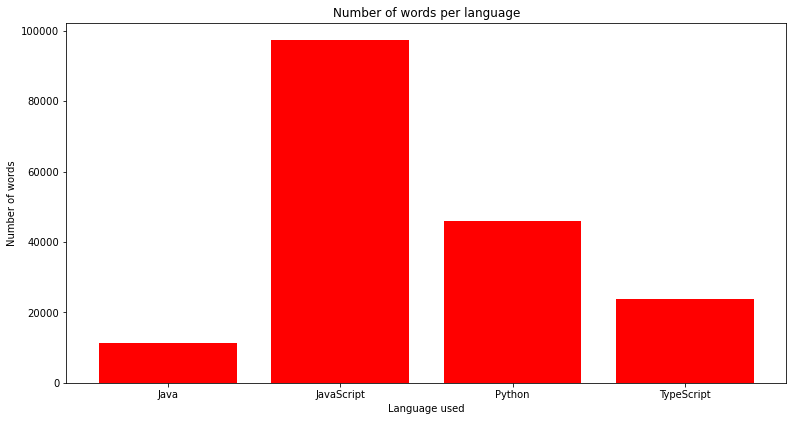

In [30]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0,0,1,1])
langs = ['Java', 'JavaScript', 'Python', 'TypeScript']
language = [Java_freq.count(), JavaScript_freq.count(), Python_freq.count(), TypeScript_freq.count()]
ax.bar(langs,language, color = 'red')
plt.xlabel("Language used")
plt.ylabel("Number of words")
plt.title("Number of words per language")

plt.show()

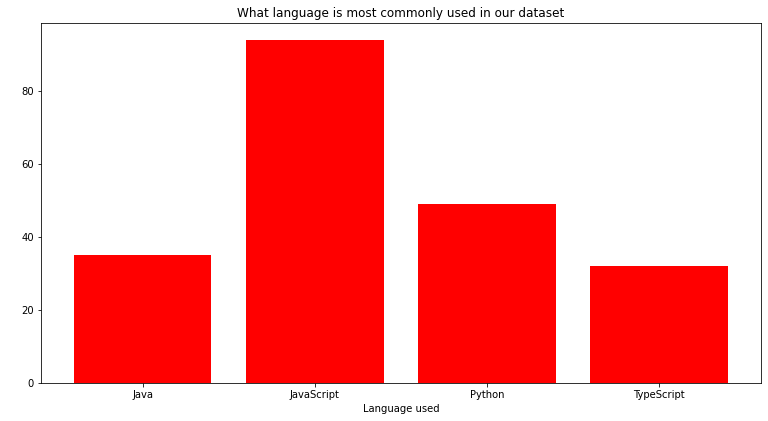

In [31]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0,0,1,1])
langs = ['Java', 'JavaScript', 'Python', 'TypeScript']
language = [len(train[train.language == 'Java']), len(train[train.language == 'JavaScript']), len(train[train.language == 'Python']), len(train[train.language == 'TypeScript'])]
ax.bar(langs,language, color = 'red')
plt.xlabel("Language used")
plt.ylabel(" ")
plt.title("What language is most commonly used in our dataset")

plt.show()

In [32]:
Java_freq.count(), JavaScript_freq.count(), Python_freq.count(), TypeScript_freq.count()

(11204, 97363, 46006, 23706)

In [33]:
len(train[train.language == 'Java']), len(train[train.language == 'JavaScript']), len(train[train.language == 'Python']), len(train[train.language == 'TypeScript'])

(35, 94, 49, 32)

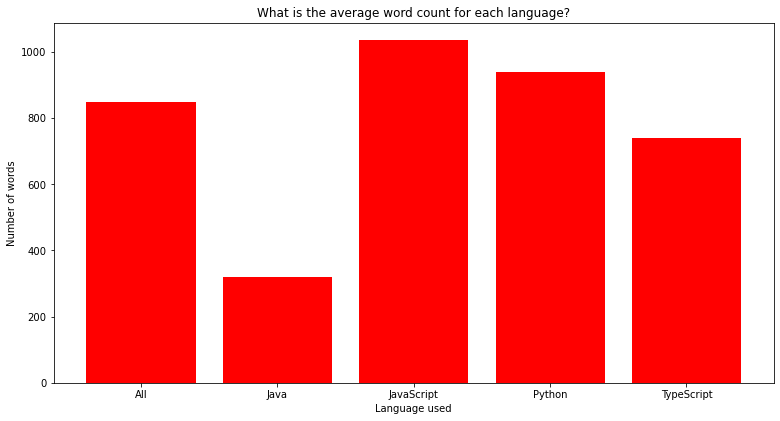

In [36]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0,0,1,1])
langs = ['All','Java', 'JavaScript', 'Python', 'TypeScript']
language = [all_freq.count()/len(train.language), Java_freq.count()/len(train[train.language == 'Java']), JavaScript_freq.count()/len(train[train.language == 'JavaScript']), Python_freq.count()/len(train[train.language == 'Python']), TypeScript_freq.count()/len(train[train.language == 'TypeScript'])]
ax.bar(langs,language, color = 'red')
plt.xlabel("Language used")
plt.ylabel("Number of words")
plt.title("What is the average word count for each language?")

plt.show()

In [37]:
train

,repo,language,readme_contents,clean_text
147,pure-css/pure,JavaScript,# Pure\n\n[![Pure](https://cloud.githubusercon...,pure purehttpscloudgithubusercontentcomassets4...
80,fex-team/fis3-demo,JavaScript,## fis3 demo\n\n聚集一些 fis3 的常用例子，每一个目录都是一个 fis3...,fis3 demo fis3 fis3 uselessuseless le usesassu...
320,openexchangerates/accounting.js,JavaScript,**accounting.js** is a tiny JavaScript library...,accountingjs tiny javascript library number mo...
66,Binaryify/NeteaseCloudMusicApi,JavaScript,# 网易云音乐 API\n\n网易云音乐 Node.js API service\n\n<p...,api nodejs api service p hrefhttpswwwnpmjscomp...
150,akveo/ngx-admin,TypeScript,"# ngx-admin [<img src=""https://i.imgur.com/oMc...",ngxadmin img srchttpsiimgurcomomcxwz0png altev...
...,...,...,...,...
372,jquery-form/form,JavaScript,# jQuery Form [![Build Status](https://travis-...,jquery form build statushttpstravisciorgjquery...
125,goldbergyoni/javascript-testing-best-practices,JavaScript,"<img src=""/assets/jtbp-header-blue.png"" width=...",img srcassetsjtbpheaderbluepng width1920px br ...
117,oitozero/ngSweetAlert,JavaScript,# AngularJS wrapper for SweetAlert\r\n\r\nAngu...,angularjs wrapper sweetalert angularjs wrapper...
124,assaf/zombie,JavaScript,"# Zombie.js\n### Insanely fast, headless full-...",zombiejs insanely fast headless fullstack test...


In [79]:
def get_chi_language(train):
    observed = pd.crosstab(train.clean_text, train.language)
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    print(f'chi^2 = {chi2:.4f}')
    print(f'p     = {p:.4f}')

In [80]:
get_chi_language(train)

chi^2 = 630.0000
p     = 0.4588


In [81]:
train.language == 'Java'

147    False
80     False
320    False
66     False
150    False
       ...  
372    False
125    False
117    False
124    False
263    False
Name: language, Length: 210, dtype: bool